In [ ]:
!pip3 install numpy pandas matplotlib

In [1]:
# Create a new conda environment with the following command:
# conda create -n bench python=3 pandas seaborn matplotlib numpy
# conda activate bench

import os
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import rcParams
from matplotlib import rcParamsDefault
from matplotlib.colors import ListedColormap
import pprint

import pandas as pd

cmap = plt.get_cmap('cividis') 
lower_limit = 0
upper_limit = 0.85
new_cmap = cmap(np.linspace(lower_limit, upper_limit, cmap.N))
#reverse the color order
new_cmap = new_cmap[::-1]
new_cmap = ListedColormap(new_cmap)

figure_save = True
figure_fmt = 'pdf'
# path_suffix = '-baseline'
path_suffix = '-best_mr_copy'

yir_mans_nice_fonts = {
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
}

rcParams.update(rcParamsDefault)
rcParams.update(yir_mans_nice_fonts)

rcParams.update({'figure.autolayout': True})


In [2]:
rcParams.update({'figure.autolayout': True})
file_path = 'results.csv'
rows = []
with open(file_path, 'r') as f:
    for line in f:
        rows.append(line.split(','))


df = pd.DataFrame.from_records(rows)
df = df.iloc[:, 0:12]
df = df.drop(columns=[11])
df.columns = ['tag', 'dims', 'kernel', 'tool', 
              'target', 'strategy', 'threads', 'board', 'value','empty', 'metric']
df['tag'] = df['tag']
df['dims'] = df['dims']
df['value'] = pd.to_numeric(df['value'], errors='coerce')
df1 = df
df = df.drop(columns=['strategy'])
df = df.drop(columns=['threads'])
df = df.drop(columns=['tag'])
df = df.drop(columns=['empty'])



# for row with the same tag print task clock metric
def process_dataframe(df, metric):
    table = {}
    for dim in df["dims"].unique():
        table[dim] = [0, 0, 0]

    for index, row in df.iterrows():
        if row['metric'] != metric:
            continue
        if row['tool'] == 'MLIR' and row['target'] == 'ACC':
            table[row['dims']][0] = row['value']
        elif row['tool'] == 'cpp_MAN' and row['target'] == 'ACC':
            table[row['dims']][1] = row['value']
    
    # loop through table and calculate speedup and save to table
    for dim in table.keys():
        table[dim][2] = table[dim][0] / table[dim][1] 
    

    stable = OrderedDict(sorted(table.items(), key=lambda k: k[0]))

    return stable


task_clock_table = process_dataframe(df, 'task-clock')
cr_table = process_dataframe(df, 'cache-references')
bi_table = process_dataframe(df, 'branch-instructions')
data_dict = {}
data_dict['Dimensions'] = [ l[2:] for l in list(task_clock_table.keys())] 
data_dict['Branch-Inst'] =  [ l[2] for l in list(bi_table.values())] 
data_dict['Cache-references'] =  [ l[2] for l in list(cr_table.values())] 
data_dict['Task-clock'] =  [ l[2] for l in list(task_clock_table.values())]



# Figure 16

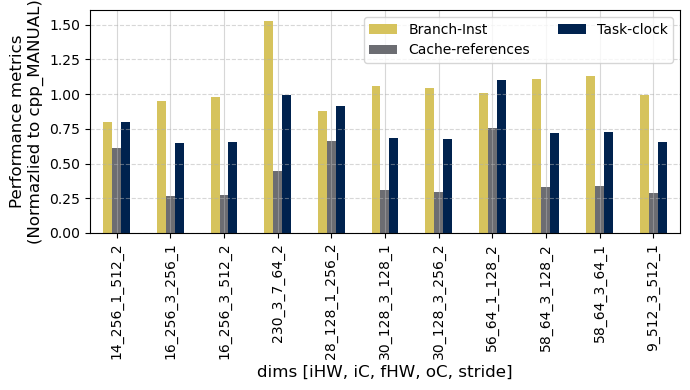

In [4]:
experiment = 'conv-runtime'
figure_size = (7, 4)
# ==============================================================================


data = pd.DataFrame(data_dict)
data = data.set_index('Dimensions')
ax = data.plot.bar(cmap=new_cmap, figsize=figure_size, rot=90)

ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylabel('Performance metrics\n(Normazlied to cpp_MANUAL)')
plt.xlabel('dims [iHW, iC, fHW, oC, stride]')
plt.legend(ncol=2)
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.grid(alpha=0.5)


if figure_save:
    plt.savefig("conv-runtime-best.pdf", format=figure_fmt)
plt.show()
